In [3]:
import time
import math
import numpy as np
from tqdm import tqdm

class LogSlowdownTQDM(tqdm):
    def __init__(self, iterable=None, *args, fit_every=50, min_points=10, **kwargs):
        if iterable is not None and 'total' not in kwargs:
            try:
                kwargs['total'] = len(iterable)
            except TypeError:
                pass  # non-sized iterator

        super().__init__(iterable=iterable, *args, **kwargs)
        self._fit_every = fit_every
        self._min_points = min_points
        self._timestamps = []
        self._iters = []
        self._a = 0.001  # sensible default
        self._b = 0.0
        self._last_fit_iter = 0
        self._iterable = iterable

    def __iter__(self):
        for item in self._iterable:
            yield item
            self._record_progress()
            super().update(1)
            self._maybe_refit()
            self._show_eta()

    def _record_progress(self):
        now = time.time()
        self._iters.append(self.n + 1)
        self._timestamps.append(now)

    def _maybe_refit(self):
        if self.n >= self._min_points and (self.n - self._last_fit_iter >= self._fit_every):
            self._fit_model()
            self._last_fit_iter = self.n

    def _fit_model(self):
        times = np.array(self._timestamps)
        iters = np.array(self._iters)

        deltas = np.diff(times)  # time per iteration
        logs = np.log(np.maximum(iters[1:], 1))  # log(i)

        A = np.vstack([np.ones_like(logs), logs]).T
        y = deltas

        try:
            coeffs, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
            self._a, self._b = coeffs
        except np.linalg.LinAlgError:
            pass

    def _show_eta(self):
        i = self.n
        N = self.total
        if i < self._min_points or N is None or i >= N:
            return

        # ∫_i^N (a + b log(x)) dx = a(N - i) + b[N log N - i log i - (N - i)]
        try:
            log_i = math.log(max(i, 1))
            log_N = math.log(N)
            eta = (
                self._a * (N - i)
                + self._b * (N * log_N - i * log_i - (N - i))
            )
            eta_str = self._format_eta(eta)
            self.set_postfix_str(f"ETA: {eta_str} | a={self._a:.4f}, b={self._b:.4f}")
        except (ValueError, ZeroDivisionError):
            pass

    def _format_eta(self, seconds: float) -> str:
        seconds = int(round(seconds))
        days, rem = divmod(seconds, 86400)
        hours, rem = divmod(rem, 3600)
        minutes, secs = divmod(rem, 60)

        parts = []
        if days > 0:
            parts.append(f"{days:02}d")
        if hours > 0 or days > 0:
            parts.append(f"{hours:02}h")
        if minutes > 0 or hours > 0 or days > 0:
            parts.append(f"{minutes:02}m")
        parts.append(f"{secs:02}s")
        return ":".join(parts)


In [4]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from typing import List, Tuple, Dict

from OverlapIndex import OverlapIndex
from OCF import OCF2
from tqdm.notebook import tqdm

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.set_num_threads(12)


# # ── CNN DEFINITION ────────────────────────────────────────────────
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.fc1   = nn.Linear(32 * 8 * 8, 128)
#         self.fc2   = nn.Linear(128, 10)

#     def forward(self, x):
#         x  = F.relu(self.conv1(x))
#         z1 = self.pool1(x)
#         x  = F.relu(self.conv2(z1))
#         z2 = self.pool2(x)
#         flat = z2.view(z2.size(0), -1)
#         z3 = F.relu(self.fc1(flat))
#         out = self.fc2(z3)
#         return out, z1, z2, z3

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        z1 = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(z1)))
        x = F.relu(self.bn4(self.conv4(x)))
        z2 = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(z2)))
        x = F.relu(self.bn6(self.conv6(x)))
        z3 = self.pool3(x)

        flat = z3.view(z3.size(0), -1)
        x = F.relu(self.fc1(flat))
        out = self.fc2(x)

        return out, z1, z2, z3



def run_condition(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test:  torch.Tensor,
    y_test:  torch.Tensor,
    batch_size: int = 50,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy"
) -> Tuple[List[List[float]], List[float], List[Tuple[float, float]], List[float]]:

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    # cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART)

    tpr_trace: List[List[float]] = []
    oi_trace:  List[float] = []
    ocf_trace: List[Tuple[float, float]] = []
    val_accuracy_trace: List[float] = []

    y_test_np = y_test.numpy()
    train_ds = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, drop_last=True, shuffle=False)

    model.train()
    for x_b, y_b in LogSlowdownTQDM(train_ds):
        x_b, y_b = x_b.to(device), y_b.to(device)

        # 1) forward + backward
        out, *_ = model(x_b)
        loss = criterion(out, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 2) eval on full test set
        model.eval()
        with torch.no_grad():
            logits_test = []
            correct = 0
            total = 0
            for i in range(0, len(X_test), 256):
                xb = X_test[i:i+256].to(device)
                logits, *_ = model(xb)
                preds = logits.argmax(dim=1)
                correct += (preds.cpu() == y_test[i:i+256]).sum().item()
                total += preds.size(0)
                logits_test.append(logits.cpu())
            logits = torch.cat(logits_test).numpy()
            val_accuracy = correct / total
            val_accuracy_trace.append(val_accuracy)
        model.train()

        # 3) TPR computation
        y_pred = logits.argmax(axis=1)
        tprs = []
        for cls in range(10):
            mask = y_test_np == cls
            tp = np.sum(y_pred[mask] == cls)
            fn = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        # # 4) OCF update
        # O, F = cf_detector.add_batch(
        #     X_train       = x_b.cpu().numpy().reshape(batch_size, -1),
        #     y_train       = y_b.cpu().numpy(),
        #     y_pred_eval   = y_pred,
        #     y_true_eval   = y_test_np,
        #     y_scores_eval = logits
        # )
        # ocf_trace.append((O, F))
        # oi_trace.append(cf_detector.OI.index)

    return tpr_trace, oi_trace, ocf_trace, val_accuracy_trace


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    X_train_all = torch.tensor(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_train_all = torch.tensor(train_ds.targets)
    X_test      = torch.tensor(test_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_test      = torch.tensor(test_ds.targets)

    traces_tpr:     Dict[str, List[List[float]]]         = {}
    traces_oi:      Dict[str, List[float]]               = {}
    traces_state:   Dict[str, List[Tuple[float, float]]] = {}
    val_acc_trace:  Dict[str, List[float]]               = {}

    for order in ("Shuffled", "Ordered"):
        if order == "Shuffled":
            idx = torch.randperm(len(y_train_all))
        else:
            idx = torch.argsort(y_train_all)

        X_train = X_train_all[idx]
        y_train = y_train_all[idx]

        print(f"→ Running CIFAR condition: {order}")
        tpr, oi, states, val_acc = run_condition(
            X_train, y_train, X_test, y_test,
            batch_size=50,
            rho=0.9,
            r_hat=np.inf,
            ART="Fuzzy"
        )
        print("Accuracy:", val_acc[-1])

        traces_tpr[order]    = tpr
        traces_oi[order]     = oi
        traces_state[order]  = states
        val_acc_trace[order] = val_acc

    # np.savez(
    #     "cf2_batch_traces_cifar_cnn.npz",
    #     ordered_tpr       = traces_tpr["Ordered"],
    #     shuffled_tpr      = traces_tpr["Shuffled"],
    #     ordered_int       = traces_oi["Ordered"],
    #     shuffled_int      = traces_oi["Shuffled"],
    #     ordered_states    = np.array(traces_state["Ordered"]),
    #     shuffled_states   = np.array(traces_state["Shuffled"]),
    #     ordered_accuracy  = val_acc_trace["Ordered"],
    #     shuffled_accuracy = val_acc_trace["Shuffled"]
    # )

    print("Saved CIFAR CNN traces with OCF2, Overlap Index, and per-batch accuracy.")


Files already downloaded and verified
Files already downloaded and verified
→ Running CIFAR condition: Shuffled


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:39:28<00:00,  9.57s/it, ETA: 09s | a=11.0337, b=-0.2425]


Accuracy: 0.6742
→ Running CIFAR condition: Ordered


 34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                  | 339/1000 [49:24<1:36:20,  8.74s/it, ETA: 01h:39m:31s | a=7.8865, b=0.1775]


KeyboardInterrupt: 

In [13]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from typing import List, Tuple, Dict

# from OverlapIndex import OverlapIndex
from OCF import OCF2
from tqdm.notebook import tqdm

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        z1 = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(z1)))
        x = F.relu(self.bn4(self.conv4(x)))
        z2 = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(z2)))
        x = F.relu(self.bn6(self.conv6(x)))
        z3 = self.pool3(x)

        flat = z3.view(z3.size(0), -1)
        x = F.relu(self.fc1(flat))
        out = self.fc2(x)

        return out, z1, z2, z3


def run_condition(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test:  torch.Tensor,
    y_test:  torch.Tensor,
    batch_size: int = 50,
    sub_batch_size: int = 5,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy",
    is_ordered: bool = False
) -> Tuple[List[List[float]], List[float], List[Tuple[float, float]], List[float]]:

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART, match_tracking="MT~")

    tpr_trace: List[List[float]] = []
    oi_trace:  List[float] = []
    ocf_trace: List[Tuple[float, float]] = []
    val_accuracy_trace: List[float] = []

    y_test_np = y_test.numpy()
    train_ds = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, drop_last=True, shuffle=False)

    model.train()
    last_class_seen = -1
    for x_b, y_b in tqdm(train_ds):
        x_b, y_b = x_b.to(device), y_b.to(device)

        if is_ordered:
        # Determine the dominant class in the batch
            current_class = y_b[0].item()  # assuming ordered and pure batches
            if current_class != last_class_seen:
                optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # reset optimizer
                last_class_seen = current_class
    
        
        prev_loss = float("inf")
        for _ in range(10):  # set a max to avoid infinite loops
            model.train()
            out, *_ = model(x_b)
            loss = criterion(out, y_b)
    
            # Check convergence
            if abs(prev_loss - loss.item()) < 1e-4:
                break
            prev_loss = loss.item()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 2) eval on full test set
        model.eval()
        with torch.no_grad():
            logits_test = []
            correct = 0
            total = 0
            for i in range(0, len(X_test), 256):
                xb = X_test[i:i+256].to(device)
                logits, *_ = model(xb)
                preds = logits.argmax(dim=1)
                correct += (preds.cpu() == y_test[i:i+256]).sum().item()
                total += preds.size(0)
                logits_test.append(logits.cpu())
            logits = torch.cat(logits_test).numpy()
            val_accuracy = correct / total
            val_accuracy_trace.append(val_accuracy)
        model.train()

        # 3) TPR computation
        y_pred = logits.argmax(axis=1)
        tprs = []
        for cls in range(10):
            mask = y_test_np == cls
            tp = np.sum(y_pred[mask] == cls)
            fn = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        indices = np.random.choice(batch_size, sub_batch_size, replace=False)
        
        # 4) OCF update with subsampled data
        O, F = cf_detector.add_batch(
            X_train       = x_b[indices].cpu().numpy().reshape(sub_batch_size, -1),
            y_train       = y_b[indices].cpu().numpy(),
            y_pred_eval   = y_pred,
            y_true_eval   = y_test_np,
            y_scores_eval = logits
        )
        ocf_trace.append((O, F))
        oi_trace.append(cf_detector.OI.index)

    return tpr_trace, oi_trace, ocf_trace, val_accuracy_trace


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    X_train_all = torch.tensor(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_train_all = torch.tensor(train_ds.targets)
    X_test      = torch.tensor(test_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_test      = torch.tensor(test_ds.targets)

    traces_tpr:     Dict[str, List[List[float]]]         = {}
    traces_oi:      Dict[str, List[float]]               = {}
    traces_state:   Dict[str, List[Tuple[float, float]]] = {}
    val_acc_trace:  Dict[str, List[float]]               = {}

    for order in ("Shuffled", "Ordered"):
        if order == "Shuffled":
            idx = torch.randperm(len(y_train_all))
        else:
            idx = torch.argsort(y_train_all)

        X_train = X_train_all[idx]
        y_train = y_train_all[idx]

        print(f"→ Running CIFAR condition: {order}")
        tpr, oi, states, val_acc = run_condition(
            X_train, y_train, X_test, y_test,
            batch_size=250,
            rho=0.9,
            r_hat=np.inf,
            ART="Fuzzy",
            is_ordered=(order == "Ordered")
        )

        traces_tpr[order]    = tpr
        traces_oi[order]     = oi
        traces_state[order]  = states
        val_acc_trace[order] = val_acc

    np.savez(
        "cf2_batch_traces_cifar_cnn_3.npz",
        ordered_tpr       = traces_tpr["Ordered"],
        shuffled_tpr      = traces_tpr["Shuffled"],
        ordered_int       = traces_oi["Ordered"],
        shuffled_int      = traces_oi["Shuffled"],
        ordered_states    = np.array(traces_state["Ordered"]),
        shuffled_states   = np.array(traces_state["Shuffled"]),
        ordered_accuracy  = val_acc_trace["Ordered"],
        shuffled_accuracy = val_acc_trace["Shuffled"]
    )

    print("Saved CIFAR CNN traces with OCF2, Overlap Index, and per-batch accuracy.")


Files already downloaded and verified
Files already downloaded and verified
→ Running CIFAR condition: Shuffled


  0%|          | 0/200 [00:00<?, ?it/s]

→ Running CIFAR condition: Ordered


  0%|          | 0/200 [00:00<?, ?it/s]

Saved CIFAR CNN traces with OCF2, Overlap Index, and per-batch accuracy.


In [10]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from ActivationKNN import KNN
from typing import List, Tuple, Dict
from tqdm.notebook import tqdm

from OverlapIndex import OverlapIndex
from OCF import OCF2


def run_condition_knn(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test:  torch.Tensor,
    y_test:  torch.Tensor,
    batch_size: int = 50,
    sub_batch_size: int = 5,
    rho: float = 0.9,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy"
) -> Tuple[List[List[float]], List[float], List[Tuple[float, float]], List[float]]:

    clf = KNN(n_neighbors=1)
    cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART, match_tracking="MT~")

    tpr_trace: List[List[float]] = []
    oi_trace:  List[float] = []
    ocf_trace: List[Tuple[float, float]] = []
    val_accuracy_trace: List[float] = []

    y_test_np = y_test.numpy()
    X_test_np = X_test.reshape(len(X_test), -1).numpy()

    # Incremental "fitting" by re-training KNN on accumulating data
    X_seen = []
    y_seen = []

    train_ds = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, drop_last=True, shuffle=False)

    for x_b, y_b in tqdm(train_ds):
        x_b_np = x_b.reshape(batch_size, -1).numpy()
        y_b_np = y_b.numpy()

        # Accumulate training data
        X_seen.append(x_b_np)
        y_seen.append(y_b_np)

        X_seen_np = np.vstack(X_seen)
        y_seen_np = np.concatenate(y_seen)

        # Train KNN on accumulated data
        clf.fit(X_seen_np, y_seen_np)

        # 1) evaluate
        y_pred = clf.predict(X_test_np)
        val_accuracy = np.mean(y_pred == y_test_np)
        val_accuracy_trace.append(val_accuracy)

        # 2) compute TPR
        tprs = []
        for cls in range(10):
            mask = y_test_np == cls
            tp = np.sum(y_pred[mask] == cls)
            fn = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        indices = np.random.choice(batch_size, sub_batch_size, replace=False)

        # 3) compute OCF indices
        y_scores = clf.activation(X_test_np)
        O, F = cf_detector.add_batch(
            X_train       = x_b_np[indices].reshape(sub_batch_size, -1),
            y_train       = y_b_np[indices],
            y_pred_eval   = y_pred,
            y_true_eval   = y_test_np,
            y_scores_eval = y_scores
        )
        ocf_trace.append((O, F))
        oi_trace.append(cf_detector.OI.index)

    return tpr_trace, oi_trace, ocf_trace, val_accuracy_trace


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    X_train_all = torch.tensor(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_train_all = torch.tensor(train_ds.targets)
    X_test      = torch.tensor(test_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_test      = torch.tensor(test_ds.targets)

    traces_tpr:     Dict[str, List[List[float]]]         = {}
    traces_oi:      Dict[str, List[float]]               = {}
    traces_state:   Dict[str, List[Tuple[float, float]]] = {}
    val_acc_trace:  Dict[str, List[float]]               = {}

    for order in ("Shuffled", "Ordered"):
        if order == "Shuffled":
            idx = torch.randperm(len(y_train_all))
        else:
            idx = torch.argsort(y_train_all)

        X_train = X_train_all[idx]
        y_train = y_train_all[idx]

        print(f"→ Running CIFAR condition: {order}")
        tpr, oi, states, val_acc = run_condition_knn(
            X_train, y_train, X_test, y_test,
            batch_size=250,
            rho=0.9,
            r_hat=np.inf,
            ART="Fuzzy"
        )

        traces_tpr[order]    = tpr
        traces_oi[order]     = oi
        traces_state[order]  = states
        val_acc_trace[order] = val_acc

    np.savez(
        "cf2_batch_traces_cifar_knn_3.npz",
        ordered_tpr       = traces_tpr["Ordered"],
        shuffled_tpr      = traces_tpr["Shuffled"],
        ordered_int       = traces_oi["Ordered"],
        shuffled_int      = traces_oi["Shuffled"],
        ordered_states    = np.array(traces_state["Ordered"]),
        shuffled_states   = np.array(traces_state["Shuffled"]),
        ordered_accuracy  = val_acc_trace["Ordered"],
        shuffled_accuracy = val_acc_trace["Shuffled"]
    )

    print("Saved CIFAR KNN traces with OCF2, Overlap Index, and per-batch accuracy.")


Files already downloaded and verified
Files already downloaded and verified
→ Running CIFAR condition: Shuffled


  0%|          | 0/200 [00:00<?, ?it/s]

→ Running CIFAR condition: Ordered


  0%|          | 0/200 [00:00<?, ?it/s]

Saved CIFAR KNN traces with OCF2, Overlap Index, and per-batch accuracy.


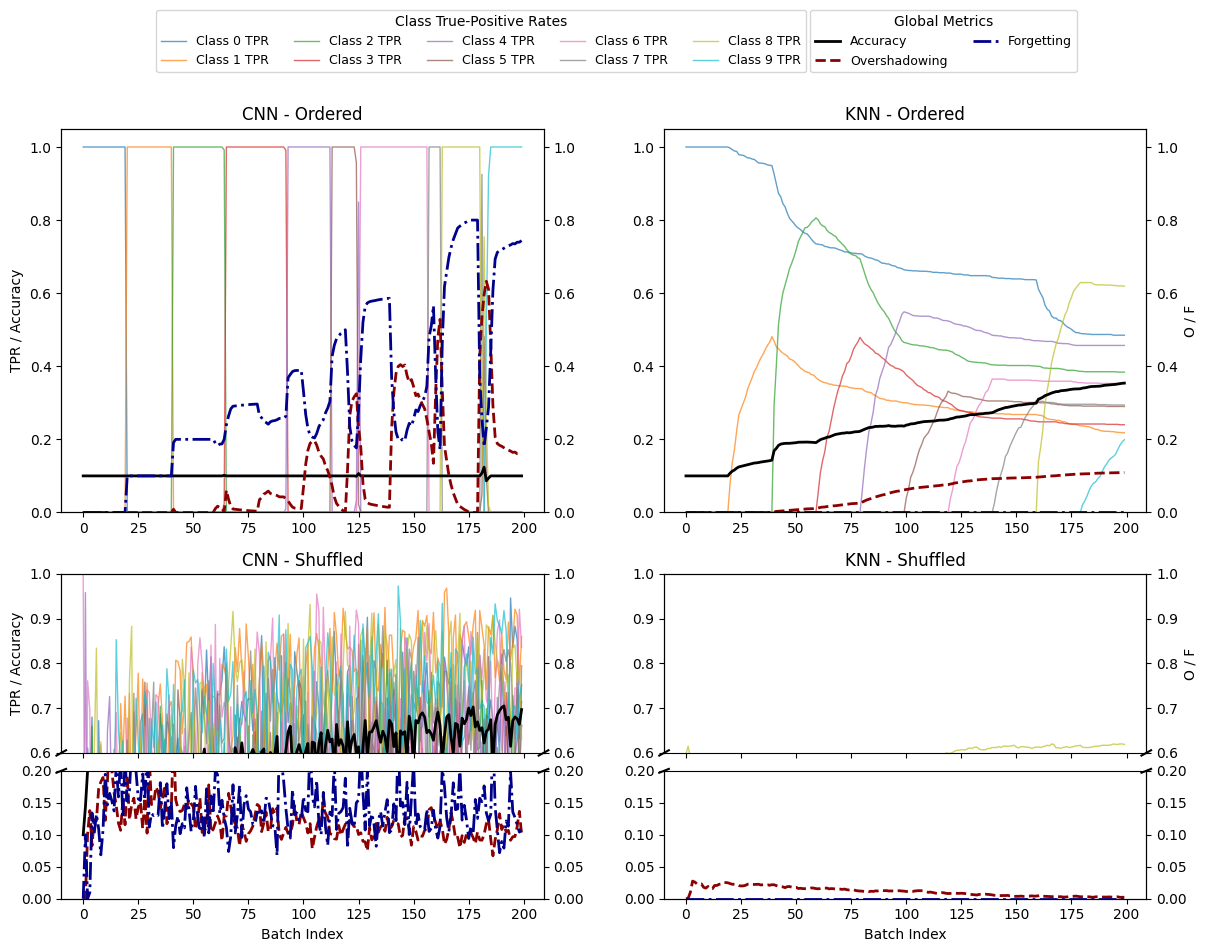

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
cnn_data = np.load("cf2_batch_traces_cifar_cnn_3.npz", allow_pickle=True)
knn_data = np.load("cf2_batch_traces_cifar_knn_3.npz", allow_pickle=True)

methods = ["CNN", "KNN"]
datasets = [cnn_data, knn_data]
orders = ["ordered", "shuffled"]
colors = plt.cm.tab10.colors
class_labels = [f"Class {i} TPR" for i in range(10)]

# === Mosaic Layout with Spacer ===
fig = plt.figure(figsize=(14, 10))
mosaic = [
    ["A", "B"],   # Ordered
    [".", "."],   # Spacer
    ["C", "D"],   # Shuffled (Top)
    ["E", "F"]    # Shuffled (Bottom)
]
ax_dict = fig.subplot_mosaic(mosaic, height_ratios=[1.5, 0.1, 0.7, 0.5])
plt.subplots_adjust(hspace=0.1, wspace=0.25, top=0.84, bottom=0.07)  # reserve top space

# Legend handles
tpr_lines = []
metric_lines = []
metric_labels = []

# === Plotting ===
for col, (method, data) in enumerate(zip(methods, datasets)):
    for row, order in enumerate(orders):
        prefix = order
        tpr = data[f"{prefix}_tpr"]
        acc = data[f"{prefix}_accuracy"]
        ocf = data[f"{prefix}_states"]
        x = np.arange(len(acc))

        if row == 0:
            ax = ax_dict[["A", "B"][col]]
            ax2 = ax.twinx()
        else:
            ax_top = ax_dict[["C", "D"][col]]
            ax_bot = ax_dict[["E", "F"][col]]
            ax = ax_top
            ax2 = ax_top.twinx()
            ax_bot2 = ax_bot.twinx()

            # Broken axis setup
            ax_top.spines['bottom'].set_visible(False)
            ax_bot.spines['top'].set_visible(False)
            ax_top.tick_params(labeltop=False)
            ax_top.set_xticklabels([])
            ax_bot.xaxis.tick_bottom()

            # Diagonal break markers
            kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
            ax_top.plot((-0.01, +0.01), (-0.015, +0.015), **kwargs)
            ax_top.plot((0.99, 1.01), (-0.015, +0.015), **kwargs)
            kwargs.update(transform=ax_bot.transAxes)
            ax_bot.plot((-0.01, +0.01), (1 - 0.015, 1 + 0.015), **kwargs)
            ax_bot.plot((0.99, 1.01), (1 - 0.015, 1 + 0.015), **kwargs)

        # Plot TPRs
        for i in range(10):
            line, = ax.plot(x, tpr[:, i], color=colors[i], linewidth=1, alpha=0.7)
            if row == 0 and col == 0:
                tpr_lines.append(line)

        # Accuracy and OCF2
        acc_line, = ax.plot(x, acc, color="black", linewidth=2)
        o_line, = ax2.plot(x, ocf[:, 0], linestyle="--", color="darkred", linewidth=2)
        f_line, = ax2.plot(x, ocf[:, 1], linestyle="-.", color="darkblue", linewidth=2)

        if row == 1:
            ax_bot.plot(x, acc, color="black", linewidth=2)
            ax_bot2.plot(x, ocf[:, 0], linestyle="--", color="darkred", linewidth=2)
            ax_bot2.plot(x, ocf[:, 1], linestyle="-.", color="darkblue", linewidth=2)

            ax.set_ylim(0.6, 1.0)
            ax2.set_ylim(0.6, 1.0)
            ax_bot.set_ylim(0.0, 0.2)
            ax_bot2.set_ylim(0.0, 0.2)

            # Centered Y-labels at break
            # ax.text(-0.08, 0.5, "TPR / Accuracy", transform=ax.transAxes,
            #         rotation=90, va='center', ha='center', fontsize=10)
            # ax2.text(1.08, 0.5, "O / F", transform=ax2.transAxes,
            #          rotation=90, va='center', ha='center', fontsize=10)
            if col == 0:
                ax.set_ylabel("TPR / Accuracy")
            if col == 1:
                ax2.set_ylabel("O / F")
        else:
            ax.set_ylim(0, 1.05)
            ax2.set_ylim(0, 1.05)
            if col == 0:
                ax.set_ylabel("TPR / Accuracy")
            if col == 1:
                ax2.set_ylabel("O / F")

        # Titles and x-labels
        ax.set_title(f"{method} - {order.capitalize()}", fontsize=12)
        if row == 1:
            ax_bot.set_xlabel("Batch Index")
        elif row == 3:
            ax.set_xlabel("Batch Index")

        if row == 0 and col == 0:
            metric_lines = [acc_line, o_line, f_line]
            metric_labels = ["Accuracy", "Overshadowing", "Forgetting"]

# === Legends (Side-by-side, Centered, Equal Height) ===
legend_y = 0.965
legend_x_offset = 0.425
fig.legend(tpr_lines, class_labels,
           loc="upper center", bbox_to_anchor=(legend_x_offset, legend_y),
           fontsize=9, title="Class True-Positive Rates", ncol=5, frameon=True)
fig.legend(metric_lines, metric_labels,
           loc="upper center", bbox_to_anchor=(legend_x_offset+0.33, legend_y),
           fontsize=9, title="Global Metrics", ncol=2, frameon=True)
plt.savefig("figures/CIFAR_OFI_CNN_KNN_2.png")
plt.show()


In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from typing import List, Tuple, Dict

# from OverlapIndex import OverlapIndex
from OCF import OCF2
from tqdm.notebook import tqdm

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # ── CNN DEFINITION ────────────────────────────────────────────────
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.fc1   = nn.Linear(32 * 8 * 8, 128)
#         self.fc2   = nn.Linear(128, 10)

#     def forward(self, x):
#         x  = F.relu(self.conv1(x))
#         z1 = self.pool1(x)
#         x  = F.relu(self.conv2(z1))
#         z2 = self.pool2(x)
#         flat = z2.view(z2.size(0), -1)
#         z3 = F.relu(self.fc1(flat))
#         out = self.fc2(z3)
#         return out, z1, z2, z3

class OptimizedCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        
        self.pool  = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x  = self.pool(F.relu(self.bn1(self.conv1(x))))
        z1 = self.pool(F.relu(self.bn2(self.conv2(x))))
        x  = self.pool(F.relu(self.bn3(self.conv3(z1))))
        z2 = x
        flat = z2.view(z2.size(0), -1)
        z3 = F.relu(self.fc1(flat))
        z3 = self.dropout(z3)
        out = self.fc2(z3)
        return out, z1, z2, z3


def run_condition(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test:  torch.Tensor,
    y_test:  torch.Tensor,
    batch_size: int = 50,
    rho: float = 0.8,
    r_hat: float = 0.1,
    ART: str   = "Fuzzy"
) -> Tuple[List[List[float]], List[float], List[Tuple[float, float]], List[float]]:

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    cf_detector = OCF2(rho=rho, r_hat=r_hat, ART=ART)

    tpr_trace: List[List[float]] = []
    oi_trace:  List[float] = []
    ocf_trace: List[Tuple[float, float]] = []
    val_accuracy_trace: List[float] = []

    y_test_np = y_test.numpy()
    train_ds = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, drop_last=True, shuffle=False)

    model.train()
    for x_b, y_b in LogSlowdownTQDM(train_ds):
        x_b, y_b = x_b.to(device), y_b.to(device)

        # 1) forward + backward
        out, *_ = model(x_b)
        loss = criterion(out, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 2) eval on full test set
        model.eval()
        with torch.no_grad():
            logits_test = []
            correct = 0
            total = 0
            for i in range(0, len(X_test), 256):
                xb = X_test[i:i+256].to(device)
                logits, *_ = model(xb)
                preds = logits.argmax(dim=1)
                correct += (preds.cpu() == y_test[i:i+256]).sum().item()
                total += preds.size(0)
                logits_test.append(logits.cpu())
            logits = torch.cat(logits_test).numpy()
            val_accuracy = correct / total
            val_accuracy_trace.append(val_accuracy)
        model.train()

        # 3) TPR computation
        y_pred = logits.argmax(axis=1)
        tprs = []
        for cls in range(10):
            mask = y_test_np == cls
            tp = np.sum(y_pred[mask] == cls)
            fn = np.sum(y_pred[mask] != cls)
            tprs.append(tp / (tp + fn) if (tp + fn) > 0 else 0.0)
        tpr_trace.append(tprs)

        # 4) OCF update
        O, F = cf_detector.add_batch(
            X_train       = x_b.cpu().numpy().reshape(batch_size, -1),
            y_train       = y_b.cpu().numpy(),
            y_pred_eval   = y_pred,
            y_true_eval   = y_test_np,
            y_scores_eval = logits
        )
        ocf_trace.append((O, F))
        oi_trace.append(cf_detector.OI.index)

    return tpr_trace, oi_trace, ocf_trace, val_accuracy_trace


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    X_train_all = torch.tensor(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_train_all = torch.tensor(train_ds.targets)
    X_test      = torch.tensor(test_ds.data).permute(0, 3, 1, 2).float() / 255.0
    y_test      = torch.tensor(test_ds.targets)

    traces_tpr:     Dict[str, List[List[float]]]         = {}
    traces_oi:      Dict[str, List[float]]               = {}
    traces_state:   Dict[str, List[Tuple[float, float]]] = {}
    val_acc_trace:  Dict[str, List[float]]               = {}

    for order in ("Shuffled", "Ordered"):
        if order == "Shuffled":
            idx = torch.randperm(len(y_train_all))
        else:
            idx = torch.argsort(y_train_all)

        X_train = X_train_all[idx]
        y_train = y_train_all[idx]

        print(f"→ Running CIFAR condition: {order}")
        tpr, oi, states, val_acc = run_condition(
            X_train, y_train, X_test, y_test,
            batch_size=50,
            rho=0.9,
            r_hat=np.inf,
            ART="Fuzzy"
        )

        traces_tpr[order]    = tpr
        traces_oi[order]     = oi
        traces_state[order]  = states
        val_acc_trace[order] = val_acc

    np.savez(
        "cf2_batch_traces_cifar_cnn_2.npz",
        ordered_tpr       = traces_tpr["Ordered"],
        shuffled_tpr      = traces_tpr["Shuffled"],
        ordered_int       = traces_oi["Ordered"],
        shuffled_int      = traces_oi["Shuffled"],
        ordered_states    = np.array(traces_state["Ordered"]),
        shuffled_states   = np.array(traces_state["Shuffled"]),
        ordered_accuracy  = val_acc_trace["Ordered"],
        shuffled_accuracy = val_acc_trace["Shuffled"]
    )

    print("Saved CIFAR CNN traces with OCF2, Overlap Index, and per-batch accuracy.")


Files already downloaded and verified
Files already downloaded and verified
→ Running CIFAR condition: Shuffled


 28%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                    | 279/1000 [2:03:40<5:19:36, 26.60s/it, ETA: 08h:13m:59s | a=-17.5671, b=9.1656]


KeyboardInterrupt: 